Initial analysis to look for possible clusters through PCA and K-means clustering


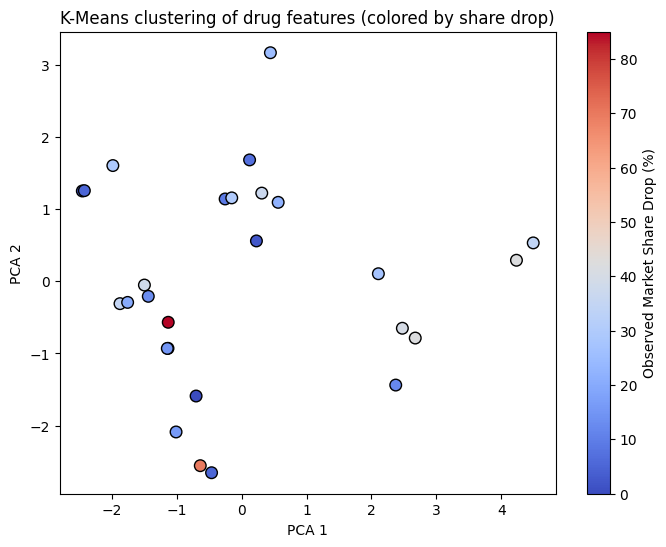

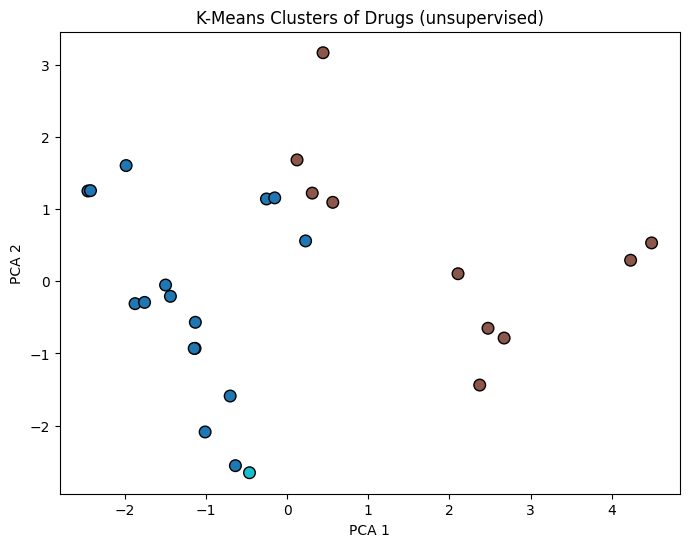

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/similarity final - similarity.csv")

features = [
	"Number of Generic Contributors",
	"Price Ratio (Q1)",
	"F1: Therapeutic Area Score (1-10)",
	"F2: MoA Novelty Score (1-10)",
	"F3: Administration Score (1-10)",
	"F4: Market Status Score (1-10)",
	"F5: Population Scale Score (1-10)",
	"F6: Price/Reimbursement Score (1-10)"
]

X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1],
					  c=df["Observed Market Share Drop (%)"],
					  cmap="coolwarm", s=70, edgecolors="k")

plt.title("K-Means clustering of drug features (colored by share drop)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
cbar = plt.colorbar(scatter)
cbar.set_label("Observed Market Share Drop (%)")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", s=70, edgecolors="k")
plt.title("K-Means Clusters of Drugs (unsupervised)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Logrithmic regression model implemented with chosen metrics


R² in log space: 0.3025090690290426
R² in original space: -0.06729841466041031
MSE in original space: 423.3207108528674

Intercept (log space): 2.8793957107875237

Feature Coefficients (log space):
Number of Generic Contributors          : -0.0137
Price Ratio (Q1)                        : 0.5029
F1: Therapeutic Area Score (1-10)       : -0.0492
F2: MoA Novelty Score (1-10)            : -0.2997
F3: Administration Score (1-10)         : 0.3304
F4: Market Status Score (1-10)          : 0.5975
F5: Population Scale Score (1-10)       : 0.1629
F6: Price/Reimbursement Score (1-10)    : -0.2441


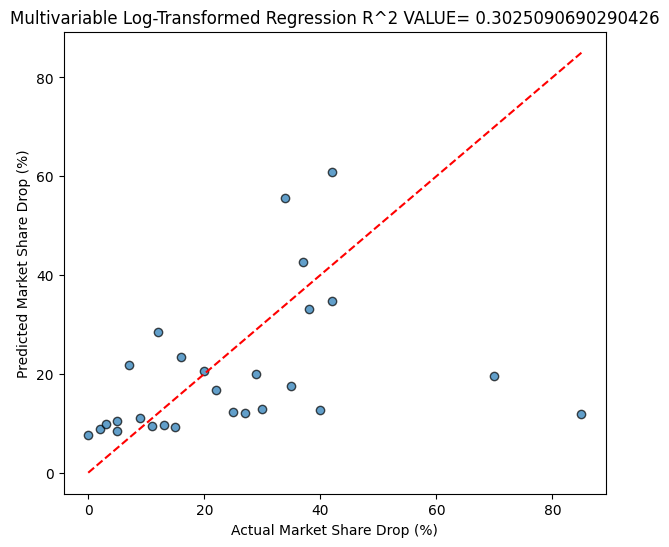

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

target = "Observed Market Share Drop (%)"

y = df[target].values

y_log = np.log1p(y)   # log(1+y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, y_log)

y_pred_log = model.predict(X_scaled)   # predictions in log space
y_pred = np.expm1(y_pred_log)          # back-transform to original space

r2_log = r2_score(y_log, y_pred_log)
r2_orig = r2_score(y, y_pred)
mse_orig = mean_squared_error(y, y_pred)

print("R² in log space:", r2_log)
print("R² in original space:", r2_orig)
print("MSE in original space:", mse_orig)

print("\nIntercept (log space):", model.intercept_)
print("\nFeature Coefficients (log space):")
for feat, coef in zip(features, model.coef_):
    print(f"{feat:40s}: {coef:.4f}")

plt.figure(figsize=(7,6))
plt.scatter(y, y_pred, edgecolors='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Market Share Drop (%)")
plt.ylabel("Predicted Market Share Drop (%)")
plt.title("Multivariable Log-Transformed Regression R^2 VALUE= " + str(r2_log))
plt.show()


Setting number of competitors to 112.2 and price ratio as 2:1 assuming 50 percent undercut for wegovy as reference

In [39]:
model.predict([[112.2,2.0,10,10,10,10,10,10]])

array([7.3244145])

Plotting relation between market share and price ratio

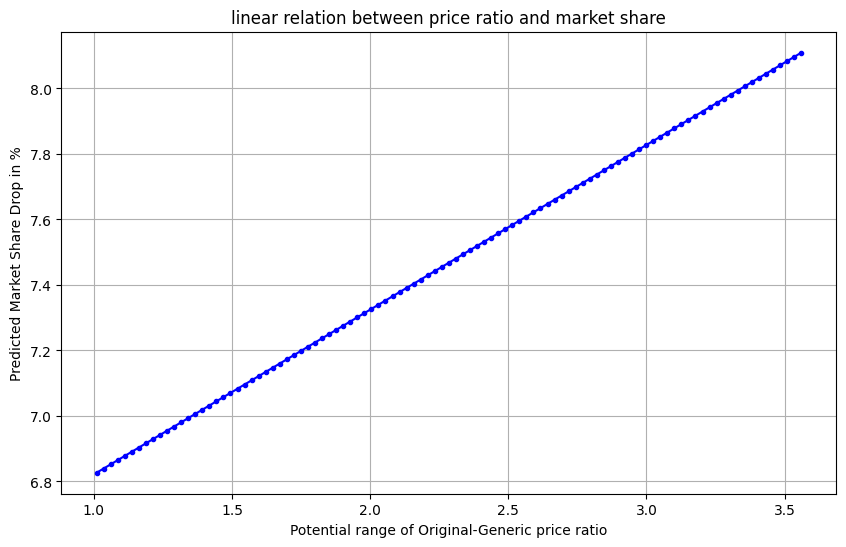

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def recursive_predict(model, base_input, lower, upper, steps=100, i=0, results=None):

    if results is None:
        results = []


    interval = (upper - lower) / steps

    # Current x value
    x_val = lower + i * interval

    # Base case: stop recursion
    if i > steps:
        return results

    # Modify first feature
    input_copy = base_input.copy()
    input_copy[1] = x_val

    # Predict
    y_pred = model.predict([input_copy])[0]  # assume scalar output
    results.append((x_val, y_pred))

    # Recursive call
    return recursive_predict(model, base_input, lower, upper, steps, i+1, results)


# --- Example Usage ---
base_input = [112.2,2.0, 10, 10, 10, 10, 10, 10]  # starting input vector
lower_bound = 1.01
upper_bound = 3.56

# Run recursive predictions
results = recursive_predict(model, base_input, lower_bound, upper_bound, steps=100)

# Convert to arrays for plotting
x_vals, y_vals = zip(*results)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(x_vals, y_vals, marker="o", markersize=3, linestyle="-", color="blue")
plt.xlabel("Potential range of Original-Generic price ratio")
plt.ylabel("Predicted Market Share Drop in %")
plt.title("linear relation between price ratio and market share")
plt.grid(True)
plt.show()


Plotting relation between market share and no. of competitors

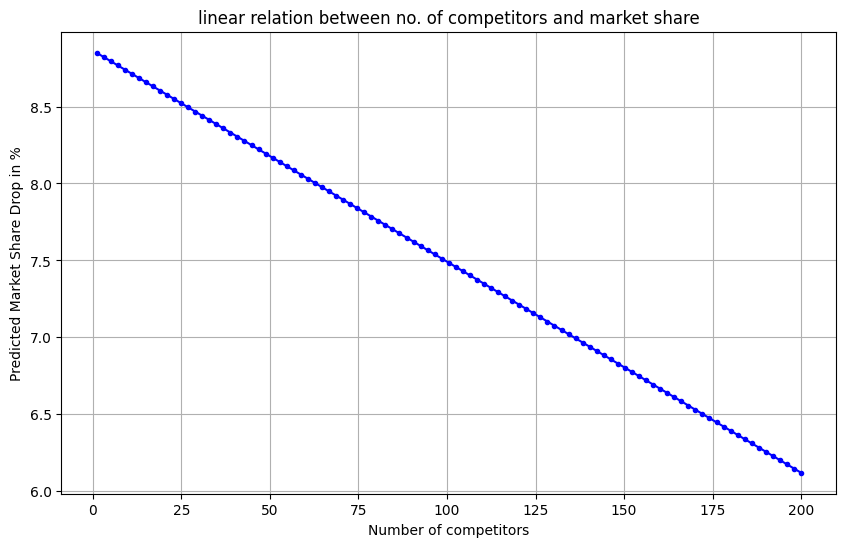

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def recursive_predict(model, base_input, lower, upper, steps=100, i=0, results=None):

    if results is None:
        results = []


    interval = (upper - lower) / steps

    # Current x value
    x_val = lower + i * interval

    # Base case: stop recursion
    if i > steps:
        return results

    # Modify first feature
    input_copy = base_input.copy()
    input_copy[0] = x_val

    # Predict
    y_pred = model.predict([input_copy])[0]  # assume scalar output
    results.append((x_val, y_pred))

    # Recursive call
    return recursive_predict(model, base_input, lower, upper, steps, i+1, results)


# --- Example Usage ---
base_input = [112.2,2.0, 10, 10, 10, 10, 10, 10]  # starting input vector
lower_bound = 1.0
upper_bound = 200.0

# Run recursive predictions
results = recursive_predict(model, base_input, lower_bound, upper_bound, steps=100)

# Convert to arrays for plotting
x_vals, y_vals = zip(*results)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(x_vals, y_vals, marker="o", markersize=3, linestyle="-", color="blue")
plt.xlabel("Number of competitors")
plt.ylabel("Predicted Market Share Drop in %")
plt.title("linear relation between no. of competitors and market share")
plt.grid(True)
plt.show()
